temp_wh.dat + manually pick spike time -- filter --sliding window pp -- pca

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/Users/xiao-zy19/Desktop/good_cs')
data = np.fromfile('temp_wh.dat', dtype=np.int16).reshape(-1, 128) #reshape((-1, 128))
print(data.shape)

(6166400, 128)


In [23]:
# design filters
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt

# Sample rate and desired cutoff frequencies
fs = 30000  # Sample rate
lowcut = 600  # High-pass filter cutoff frequency
highcut = 1000  # High corner frequency for the band-pass filter
lowcut_bp = 30  # Low corner frequency for the band-pass filter

# Butterworth High-Pass Filter
def butter_highpass(cutoff, fs, order=10):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Band-Pass Filter
def butter_bandpass(lowcut_bp, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut_bp / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def apply_filter(data, b, a):
    y = filtfilt(b, a, data)
    return y

# initialize the filters
b_high, a_high = butter_highpass(lowcut, fs, order=10)
b_band, a_band = butter_bandpass(lowcut_bp, highcut, fs, order=3)

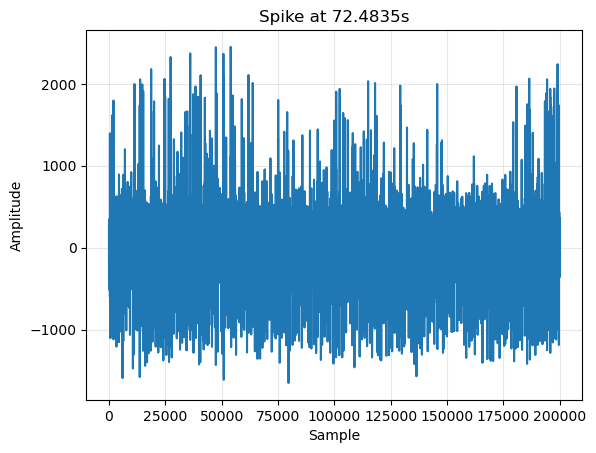

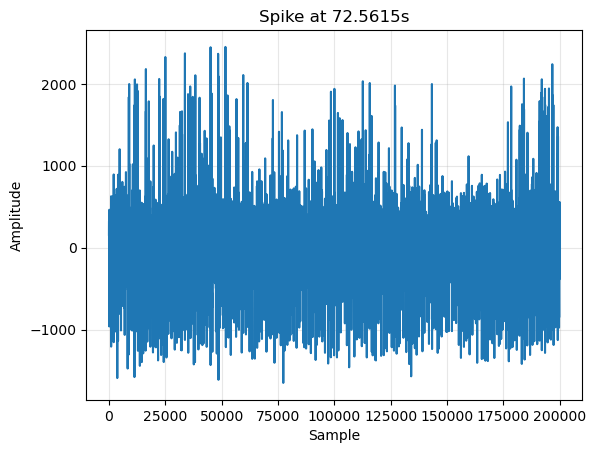

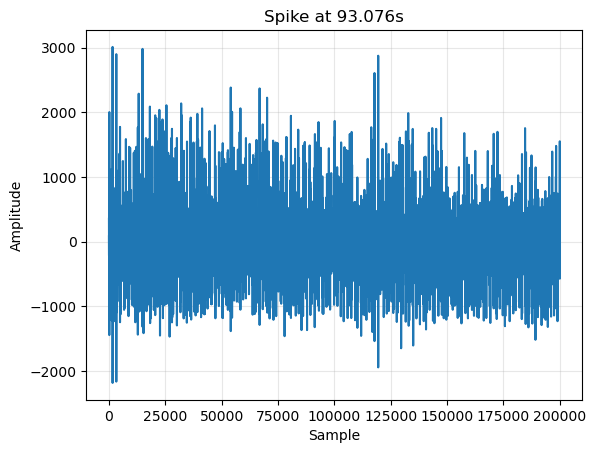

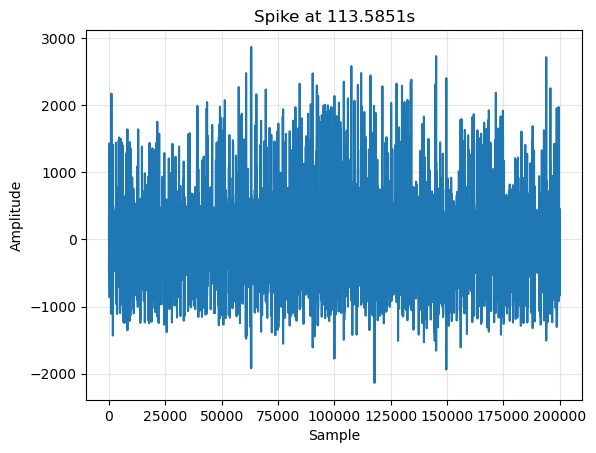

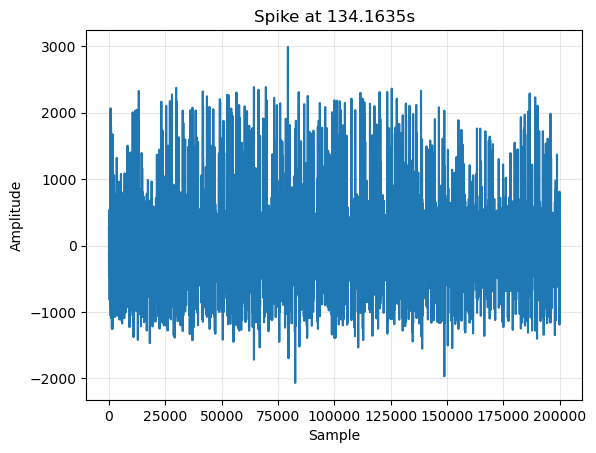

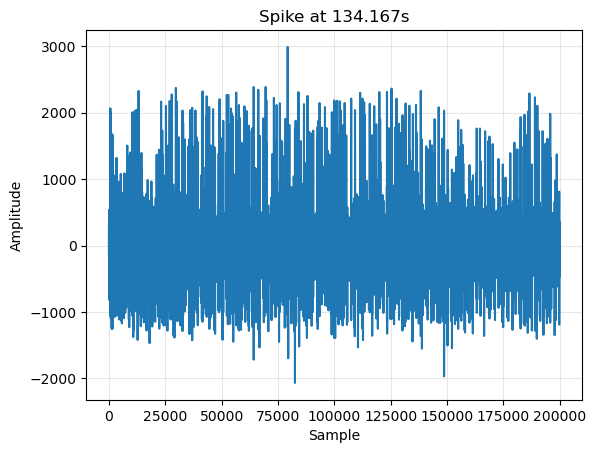

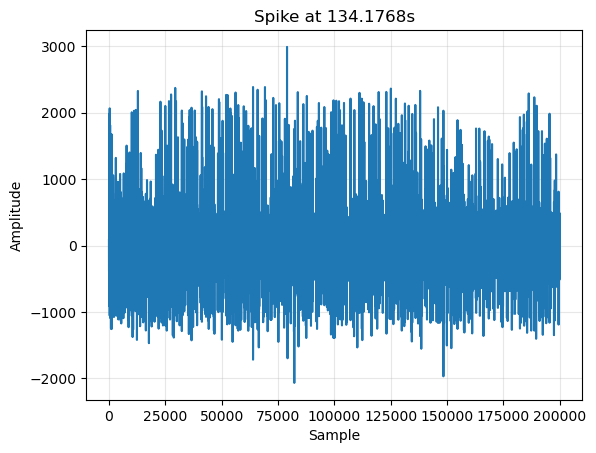

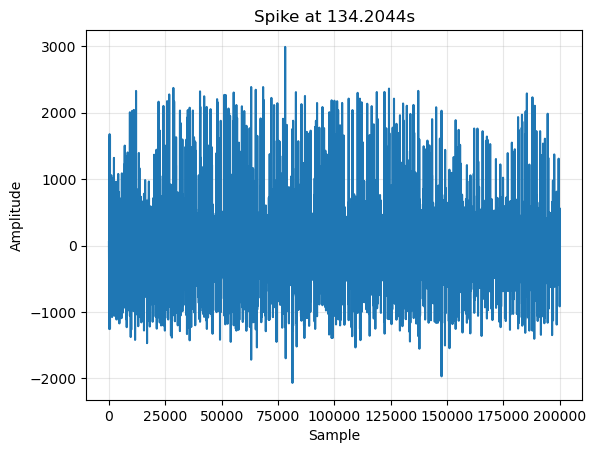

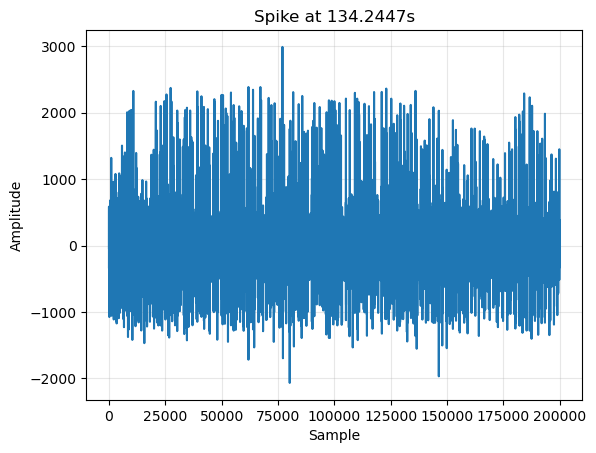

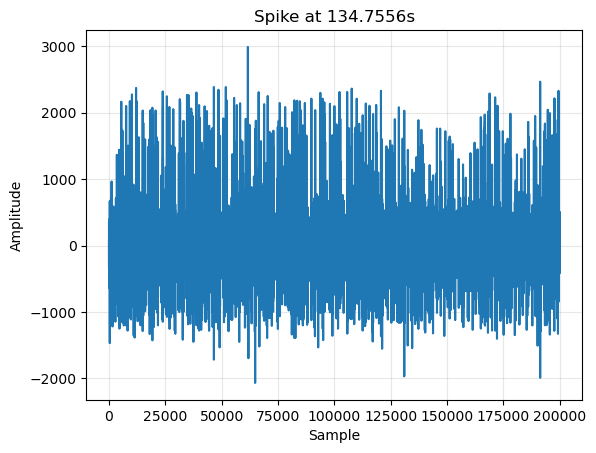

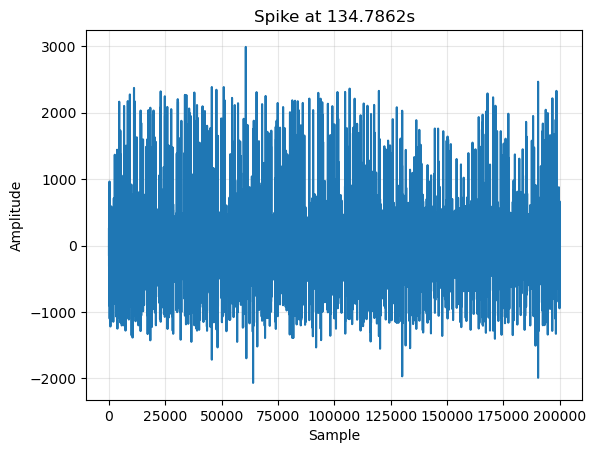

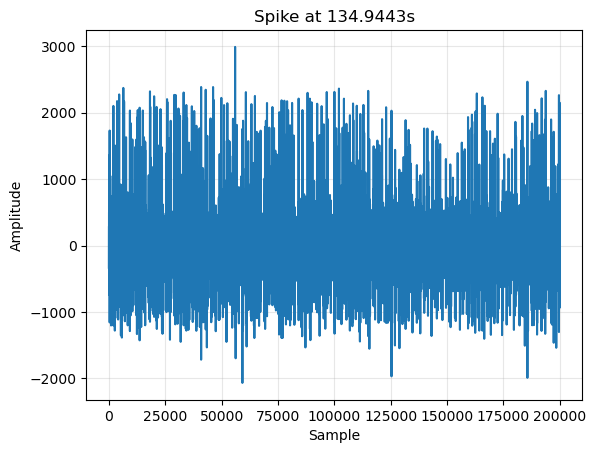

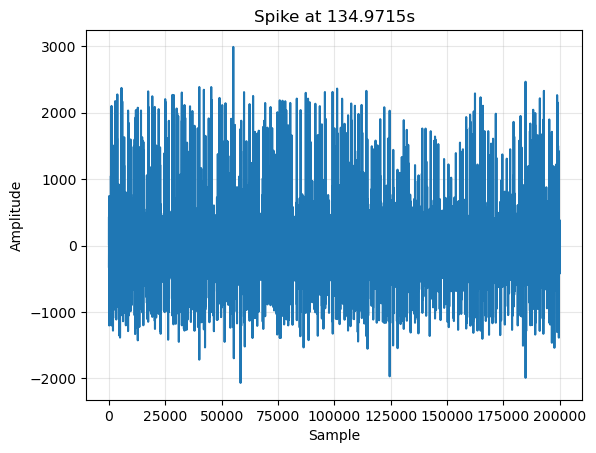

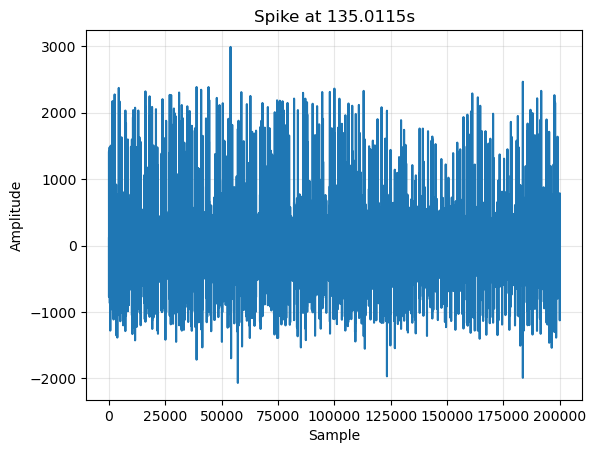

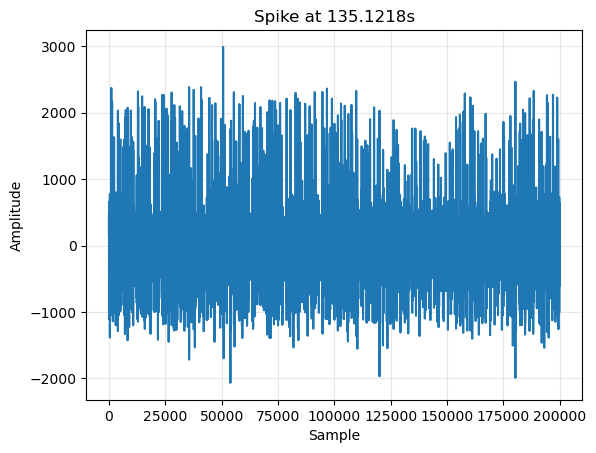

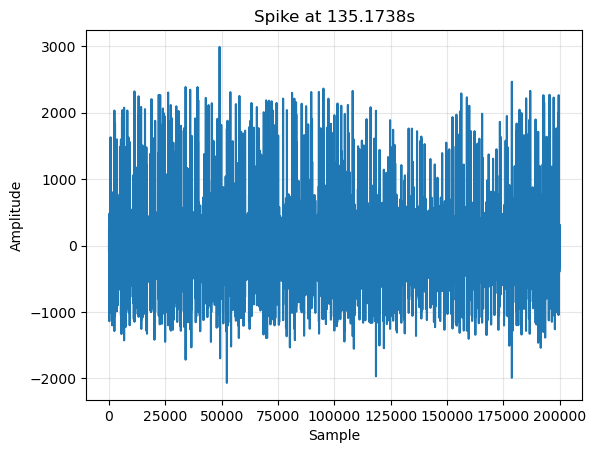

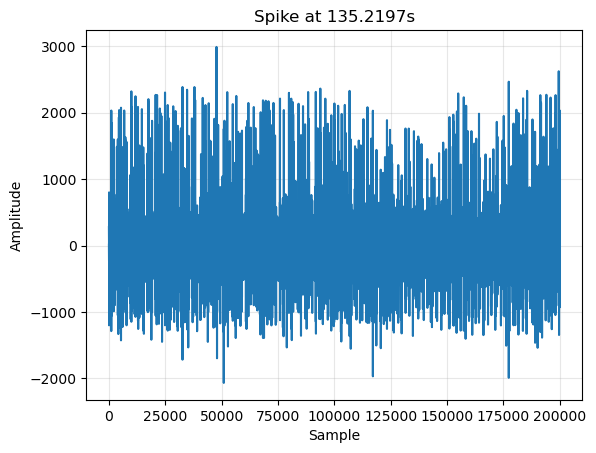

In [24]:
channel23 = data[:, 23]
channel23 = apply_filter(channel23, b_high, a_high)

complex_spike_time = [72.4835, 72.5615, 93.076, 113.5851, 134.1635, 134.167, 134.1768, 134.2044, 134.2447, 134.7556, 134.7862, 134.9443, 134.9715, 135.0115, 135.1218, 135.1738, 135.2197] #  93.076,
complex_spike_index = [int(x*30000) for x in complex_spike_time]
# print(complex_spike_index)

channel22 = data[:, 22]

simple_spike_time = [134.4425, 134.478, 134.507, 134.5435, 134.583, 134.6287, 134.673, 134.7561, 134.7994, 134.8425]
simple_spike_index = [int(x*30000) for x in simple_spike_time]

# for i in range(len(simple_spike_index)):
#     plt.figure()
#     plt.plot(channel22[simple_spike_index[i]-100:simple_spike_index[i]+100])
#     plt.title(f'Spike at {simple_spike_time[i]}s')
#     plt.xlabel('Sample')
#     plt.ylabel('Amplitude')
#     plt.grid(alpha=0.3)
#     plt.show()

for i in range(len(complex_spike_index)):
    plt.figure()
    plt.plot(channel23[complex_spike_index[i]-100000:complex_spike_index[i]+100000])
    plt.title(f'Spike at {complex_spike_time[i]}s')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.3)
    plt.show()

In [25]:
# randomly repeat complex spike index
complex_spike_index = complex_spike_index * 100
new_signal1 = np.zeros(300)
for i in range(len(complex_spike_index)):
    new_signal1 = np.concatenate((new_signal1, channel23[complex_spike_index[i]-300:complex_spike_index[i]+300], np.zeros(300)), axis=0)
# new_signal1 = new_signal1[200:]
print(new_signal1.shape)

# repeat simple spike index 6 times
simple_spike_index = simple_spike_index * 100
new_signal2 = np.zeros(300)
for i in range(len(simple_spike_index)):
    new_signal2 = np.concatenate((new_signal2, channel22[simple_spike_index[i]-300:simple_spike_index[i]+300], np.zeros(300)), axis=0)
new_signal2 = new_signal2[300:]
print(new_signal2.shape)

# concatenate the two signals
new_signal = np.concatenate((new_signal1, new_signal2), axis=0)
print(new_signal.shape)

# add random noise to the signal
noise = np.random.normal(0, 100, len(new_signal))
# noise = np.zeros(len(new_signal))
noisy_signal = new_signal + noise

(1530300,)
(900000,)
(2430300,)


In [26]:
def slide_pp(data, window_size=300, step_size=100, peak_points=None):

    results = {"start_index": [], "peak_index": [], "peak_to_peak_value": []}
    if peak_points is None:
        for start in range(0, len(data) - window_size + 1, step_size):
            end = start + window_size
            window_data = data[start:end]

            max_val = np.max(window_data)
            min_val = np.min(window_data)
            max_index = np.argmax(window_data) + start
            min_index = np.argmin(window_data) + start

            peak_index = (max_index + min_index) // 2
            peak_to_peak = max_val - min_val

            results["start_index"].append(start)
            results["peak_index"].append(peak_index)
            results["peak_to_peak_value"].append(peak_to_peak)
    else:
        for center in peak_points:
            start = center - window_size // 2
            end = start + window_size
            window_data = data[start:end]

            max_val = np.max(window_data)
            min_val = np.min(window_data)
            max_index = np.argmax(window_data) + start
            min_index = np.argmin(window_data) + start

            peak_index = (max_index + min_index) // 2
            peak_to_peak = max_val - min_val

            results["start_index"].append(start)
            results["peak_index"].append(peak_index)
            results["peak_to_peak_value"].append(peak_to_peak)
    return results

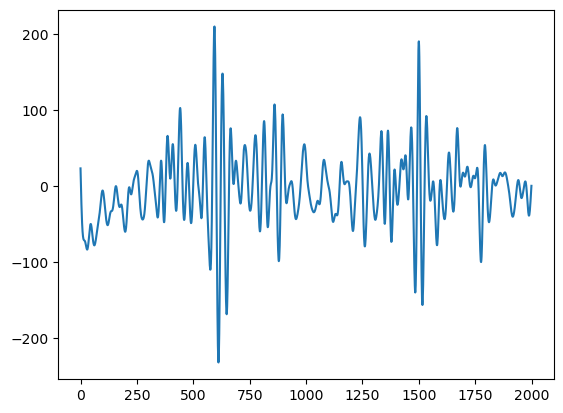

[   2403   10506   17704   22207   33004   48304   63604   78903   94203
  109504  124803  140104  148206  155403  170703  186003  201303  216604
  231903  247268  262503  277804  293103  308404  323704  339003  354304
  369603  384904  400204  415503  430803  446103  461403  476704  492004
  507303  522603  537904  553203  568504  583804  599104  614403  629703
  645004  660304  675603  690904  706203  721504  726007  736804  752104
  767403  782704  798003  813304  817807  828603  833107  836706  843903
  859204  874504  889803  905103  920403  935703  951003  966304  981604
  996904 1012204 1027503 1042803 1058103 1073404 1088704 1104003 1119303
 1134604 1149903 1165203 1169707 1180504 1195803 1211103 1226403 1241703
 1257068 1272304 1280406 1287603 1302904 1318203 1333503 1348804 1364104
 1379403 1394704 1410004 1425303 1440603 1455903 1464006 1471204 1479306
 1486503 1501804 1517103 1530611 1531506 1532409 1533313 1534200 1539611
 1540506 1541410 1542314 1543200 1544105 1547710 15

In [27]:
low_freq_data = apply_filter(noisy_signal, b_band, a_band)
high_freq_data = apply_filter(noisy_signal, b_high, a_high)
plt.figure()
plt.plot(low_freq_data[:2000])
plt.show()


results = slide_pp(low_freq_data, window_size=300, step_size=100)
peak_points = results['peak_index']
peak_values = results['peak_to_peak_value']
# peak threshold
threshold = 600

# find the peak points that are above the threshold, along with their corresponding peak index
peak_points = [peak_points[i] for i in range(len(peak_points)) if peak_values[i] > threshold]
peak_points = list(set(peak_points))
peak_points.sort()
peak_points = np.array(peak_points)

re_results = slide_pp(low_freq_data, window_size=300, step_size=100, peak_points=peak_points)

del peak_points, peak_values

peak_points = re_results['peak_index']
peak_values = re_results['peak_to_peak_value']
peak_points = list(set(peak_points))
peak_points.sort()
peak_points = np.array(peak_points)
print(peak_points)

# plt.figure()
# plt.plot(peak_points[:50], peak_values[:50])
# plt.axvline(x=600, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.axvline(x=1500, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.axvline(x=2400, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.axvline(x=3300, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.axvline(x=4200, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.axvline(x=5100, color='r', linestyle='--', label='Peaks', alpha=0.5)
# plt.grid(linestyle='--', alpha=0.5)
# plt.show()

# plt.figure()
# plt.plot(peak_points[-100:], peak_values[-100:])
# plt.grid(linestyle='--', alpha=0.5)
# plt.show()

In [28]:
low_pre_ms = 2
low_segment_ms = 10
high_pre_ms = 0.5
high_segment_ms = 2

low_freq_segments = []
high_freq_segments = []
labels = []

for point in peak_points:
    if point - low_pre_ms * fs / 1000 < 0 or point + low_segment_ms * fs / 1000 > len(low_freq_data):
        continue
    start_low = int(point - low_pre_ms * fs / 1000)
    end_low = int(start_low + low_segment_ms * fs / 1000)
    
    start_high = int(point - high_pre_ms * fs / 1000)
    end_high = int(start_high + high_segment_ms * fs / 1000)
    low_freq_segments.append(low_freq_data[start_low:end_low])
    high_freq_segments.append(high_freq_data[start_high:end_high])
    
    # if point < len(new_signal1):
    #     labels.append(0)
    # else:
    #     labels.append(1)
    
    if point < len(new_signal1) and point % 900 < 750 and point % 900 > 375:
        labels.append(0)
    elif point > len(new_signal1) and point % 900 < 750 and point % 900 > 375: 
        labels.append(1)
    else: 
        labels.append(2)
    
low_freq_segments = np.array(low_freq_segments)
high_freq_segments = np.array(high_freq_segments)

# align the high_freq_segments
for i, segment in enumerate(high_freq_segments):
    peak_index = np.argmax(segment)  # Find the peak index
    start_adjusted = max(0, peak_index - int(2 * fs / 1000))  # Adjust start
    end_adjusted = min(len(segment), peak_index + int(5 * fs / 1000))  # Adjust end index
    high_freq_segments[i] = segment[start_adjusted:end_adjusted]

In [29]:
from sklearn.decomposition import PCA

# Flatten the segments
low_freq_vectors = low_freq_segments.reshape(low_freq_segments.shape[0], -1)
high_freq_vectors = high_freq_segments.reshape(high_freq_segments.shape[0], -1)
print(f'low freq vectors shape: {low_freq_vectors.shape}, high freq vectors shape: {high_freq_vectors.shape}')

# Perform PCA
pca_low = PCA(n_components=2)
pca_high = PCA(n_components=2)

low_freq_pca = pca_low.fit_transform(low_freq_vectors)
high_freq_pca = pca_high.fit_transform(high_freq_vectors)
print(f'low freq pca shape: {low_freq_pca.shape}, high freq pca shape: {high_freq_pca.shape}')

low freq vectors shape: (686, 300), high freq vectors shape: (686, 60)
low freq pca shape: (686, 2), high freq pca shape: (686, 2)


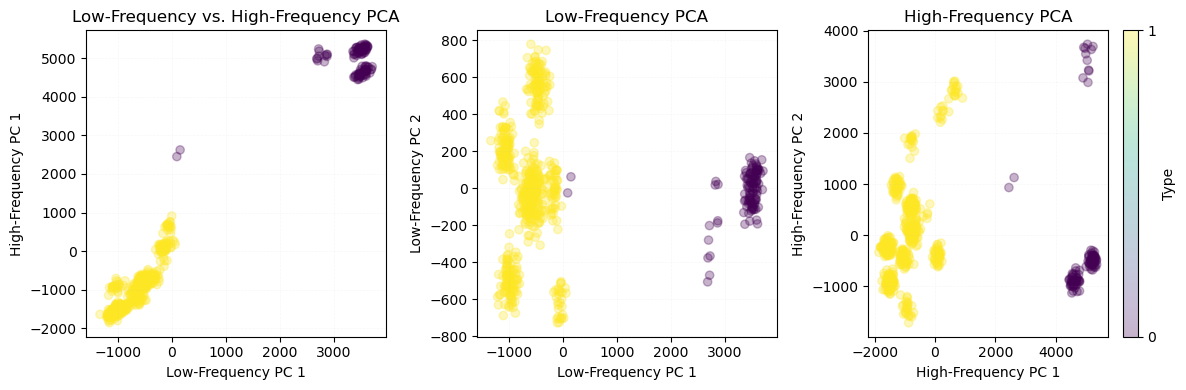

In [30]:
import matplotlib.pyplot as plt

# Plotting PCA results for low-frequency data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_pca[:, 0], high_freq_pca[:, 0], alpha=0.3, c=labels, cmap='viridis')
plt.title('Low-Frequency vs. High-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('High-Frequency PC 1')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.1)

plt.subplot(1, 3, 2)
plt.scatter(low_freq_pca[:, 0], low_freq_pca[:, 1], alpha=0.3, c=labels, cmap='viridis')
plt.title('Low-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('Low-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.1)

plt.subplot(1, 3, 3)
plt.scatter(high_freq_pca[:, 0], high_freq_pca[:, 1], alpha=0.3, c=labels, cmap='viridis')
plt.title('High-Frequency PCA')
plt.xlabel('High-Frequency PC 1')
plt.ylabel('High-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.1)

plt.colorbar(label='Type', ticks=[0, 1, 2])
plt.tight_layout()
plt.show()

/Users/xiao-zy19/anaconda3/envs/bds/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/xiao-zy19/anaconda3/envs/bds/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


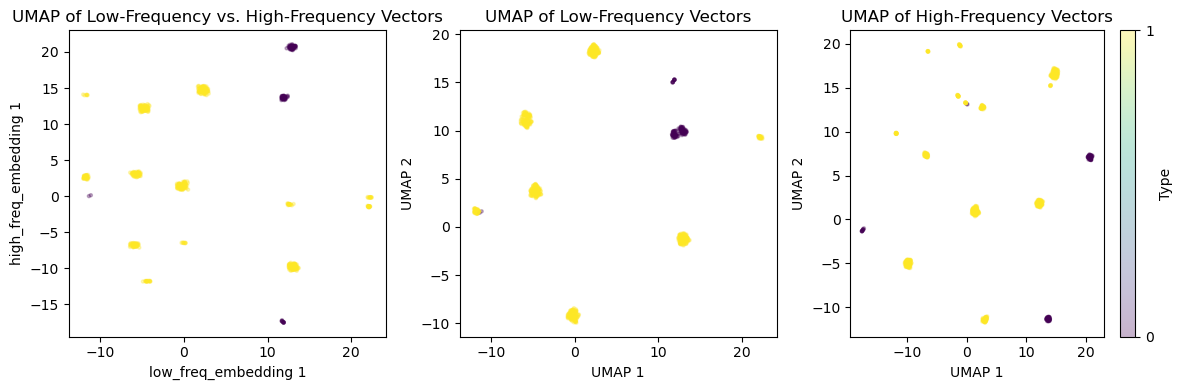

In [31]:
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt

# UMAP for Low-Frequency Vectors
reducer_low = umap.UMAP()
low_freq_embedding = reducer_low.fit_transform(low_freq_vectors)

# UMAP for High-Frequency Vectors
reducer_high = umap.UMAP()
high_freq_embedding = reducer_high.fit_transform(high_freq_vectors)

clusterer_low = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer_low.fit(low_freq_embedding)
labels_low = clusterer_low.labels_

clusterer_high = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
clusterer_high.fit(high_freq_embedding)
labels_high = clusterer_high.labels_

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_embedding[:, 0], high_freq_embedding[:, 0], s=5, alpha=0.3, c=labels, cmap='viridis')
plt.title('UMAP of Low-Frequency vs. High-Frequency Vectors')
plt.xlabel('low_freq_embedding 1')
plt.ylabel('high_freq_embedding 1')

plt.subplot(1, 3, 2)
plt.scatter(low_freq_embedding[:, 0], low_freq_embedding[:, 1], s=5, alpha=0.3, c=labels, cmap='viridis')
plt.title('UMAP of Low-Frequency Vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.subplot(1, 3, 3)
plt.scatter(high_freq_embedding[:, 0], high_freq_embedding[:, 1], s=5, alpha=0.3, c=labels, cmap='viridis') 
plt.title('UMAP of High-Frequency Vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.colorbar(label='Type', ticks=[0, 1, 2])
plt.tight_layout()
plt.show()